In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [35]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [36]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              15680     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 71,361
Trainable params: 71,361
Non-trainable params: 0
_______________________________________________________

In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [38]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 53s 95ms/step - loss: 257.2504 - reconstruction_loss: 202.5250 - kl_loss: 3.4036
Epoch 2/10
547/547 [==============================] - 49s 90ms/step - loss: 169.4164 - reconstruction_loss: 162.3045 - kl_loss: 4.9273
Epoch 3/10
547/547 [==============================] - 54s 99ms/step - loss: 162.5990 - reconstruction_loss: 156.6670 - kl_loss: 5.2519
Epoch 4/10
547/547 [==============================] - 71s 130ms/step - loss: 159.6035 - reconstruction_loss: 154.2739 - kl_loss: 5.3948
Epoch 5/10
547/547 [==============================] - 105s 192ms/step - loss: 158.3381 - reconstruction_loss: 152.6662 - kl_loss: 5.5092
Epoch 6/10
547/547 [==============================] - 100s 183ms/step - loss: 157.4259 - reconstruction_loss: 151.5780 - kl_loss: 5.5842
Epoch 7/10
547/547 [==============================] - 113s 206ms/step - loss: 156.4203 - reconstruction_loss: 150.2445 - kl_loss: 5.6913
Epoch 8/10
547/547 [============================

In [43]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

InvalidArgumentError:  Matrix size-incompatible: In[0]: [1,2], In[1]: [4,3136]
	 [[node decoder/dense_5/Relu (defined at <ipython-input-43-2dbe6e0da057>:17) ]] [Op:__inference_predict_function_161478]

Function call stack:
predict_function


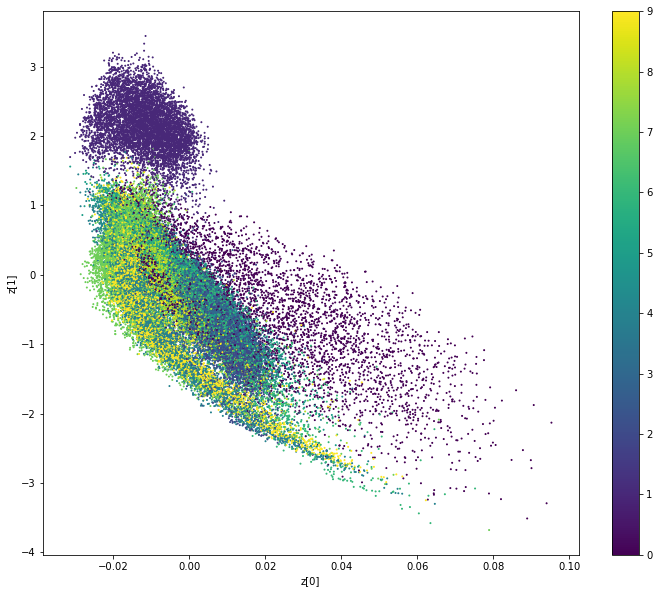

In [40]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, s=1)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

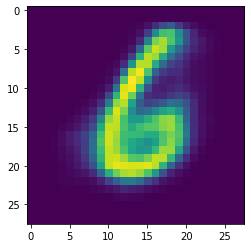

In [46]:
x=np.reshape(np.array([.401,.2,.0,.9]),(1,4))
plt.imshow(decoder.predict(x)[0,:,:,0])